In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import subtractr.utils as utils
import subtractr.utils.circuitmap_utils as cm_utils
import h5py


In [87]:
# results_with = np.load('../figures/full_pipeline/220330_cell4_emx_IC/220330_cell4_emx_ic_mapB_A_cmReformat_targeted-with-nps_results.npz', allow_pickle=True)
results = np.load('../figures/targeted/220330_cell4_emx_ic_mapB_A_cmReformat_subtraction_comparison_results.npz', allow_pickle=True)

In [4]:
class ComparisonResults:
    def __init__(self, results_path):
        results = np.load(results_path, allow_pickle=True)
        self.results = results

    def get_stim_mat(self, singlespot=True, multispot=True):
        stim_mat = []
        if singlespot:
            stim_mat.append(self.results['singlespot'].item()['stim_mat'])
        if multispot:
            stim_mat.append(self.results['multispot'].item()['stim_mat'])
        return np.concatenate(stim_mat, axis=1)

    def get_singlespot_weights(self, subtracted=True):
        if subtracted:
            return self.results['singlespot'].item()['model_state_subtraction_on']['mu']
        else:
            return self.results['singlespot'].item()['model_state_subtraction_off']['mu']

    def get_multispot_weights(self, subtracted=True):
        if subtracted:
            return self.results['multispot'].item()['model_state_subtraction_on']['mu']
        else:
            return self.results['multispot'].item()['model_state_subtraction_off']['mu']

    def get_singlespot_model_state(self, subtracted=True):
        if subtracted:
            return self.results['singlespot'].item()['model_state_subtraction_on']
        else:
            return self.results['singlespot'].item()['model_state_subtraction_off']

    def get_singlespot_pscs(self, subtracted=True, neuron_idxs=None):
        stim_mat = self.get_stim_mat(singlespot=True, multispot=False)
        N = stim_mat.shape[0]
        if neuron_idxs is None:
            neuron_idxs = np.arange(N)
        stim_idxs = np.where(stim_mat[neuron_idxs, :].sum(axis=0) > 0)[0]
        if subtracted:
            return self.results['singlespot'].item()['subtracted'][stim_idxs,:]
        else:
            return self.results['singlespot'].item()['raw'][stim_idxs,:]

    def get_targets(self):
        return self.results['targets']


R = ComparisonResults('../figures/targeted/220330_cell4_emx_ic_mapB_A_cmReformat_subtraction_comparison_results.npz')

In [5]:
def compute_waveforms_by_power(powers, raw_traces, model_state):
    num_powers = len(np.unique(powers))
    timesteps = raw_traces.shape[1]
    mu = model_state['mu']
    num_neurons = mu.shape[0]

    waveforms = np.zeros((num_neurons, num_powers, timesteps))
    for pidx, power in enumerate(np.unique(powers)):
        these_trials = powers == power
        lam_curr = model_state['lam'][:, these_trials]
        raw_psc_curr = raw_traces[these_trials, :]
        waveforms[:, pidx, :] = utils.estimate_spike_waveforms(lam_curr, raw_psc_curr)
    return waveforms

# Estimate spike waveforms for each power
ss_powers = np.max(R.get_stim_mat(singlespot=True, multispot=False), axis=0)

ss_waveforms_with_nps = compute_waveforms_by_power(ss_powers,
    R.get_singlespot_pscs(subtracted=True), 
    R.get_singlespot_model_state(subtracted=True))

ss_waveforms_without_nps = compute_waveforms_by_power(ss_powers,
    R.get_singlespot_pscs(subtracted=False), 
    R.get_singlespot_model_state(subtracted=False))

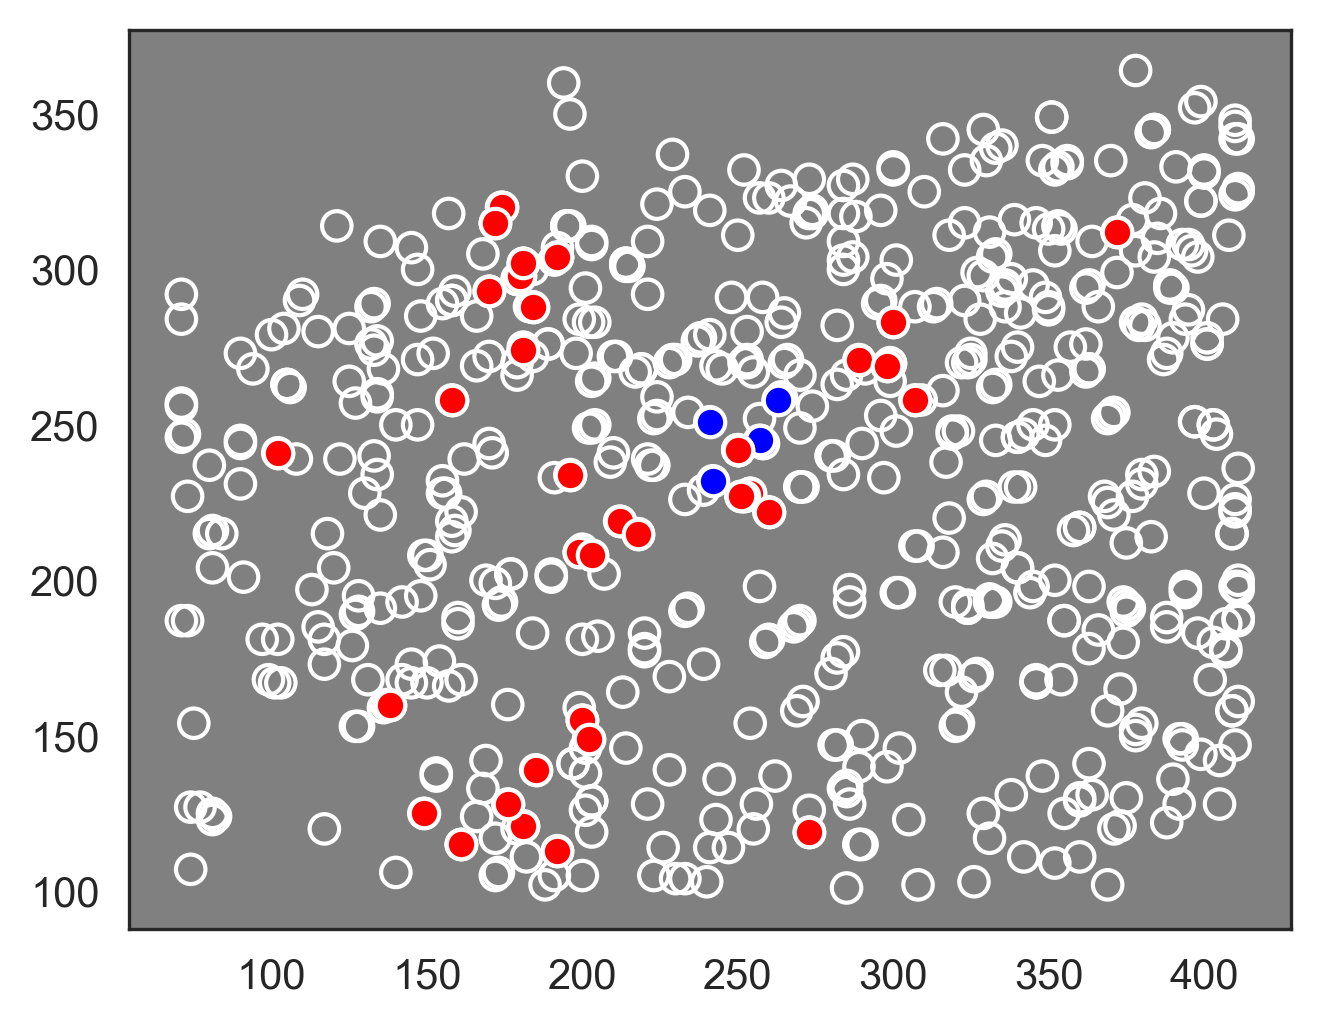

In [124]:
def plot_before_after_spatial(mu_with, mu_without, targets):
    fig = plt.figure(figsize=(5,5), dpi=300)

    connected_idxs_without = np.where(mu_without > 0)[0]
    connected_idxs_with = np.where(mu_with > 0)[0]

    # set background to gray
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_facecolor('gray')

    # plot targeted locations as white circles
    plt.scatter(targets[:, 0], targets[:, 1], facecolors='none', edgecolors='white', s=50)

    # fill in neurons we find as connected without subtraction
    plt.scatter(targets[connected_idxs_without, 0], targets[connected_idxs_without, 1],
        facecolors='blue', edgecolors='white', s=50)
    # fill in neurons we find as connected with subtraction
    plt.scatter(targets[connected_idxs_with, 0], targets[connected_idxs_with, 1],
        facecolors='red', edgecolors='white', s=50)
    
plot_before_after_spatial(
    R.get_singlespot_weights(subtracted=True),
    R.get_singlespot_weights(subtracted=False),
    R.get_targets())

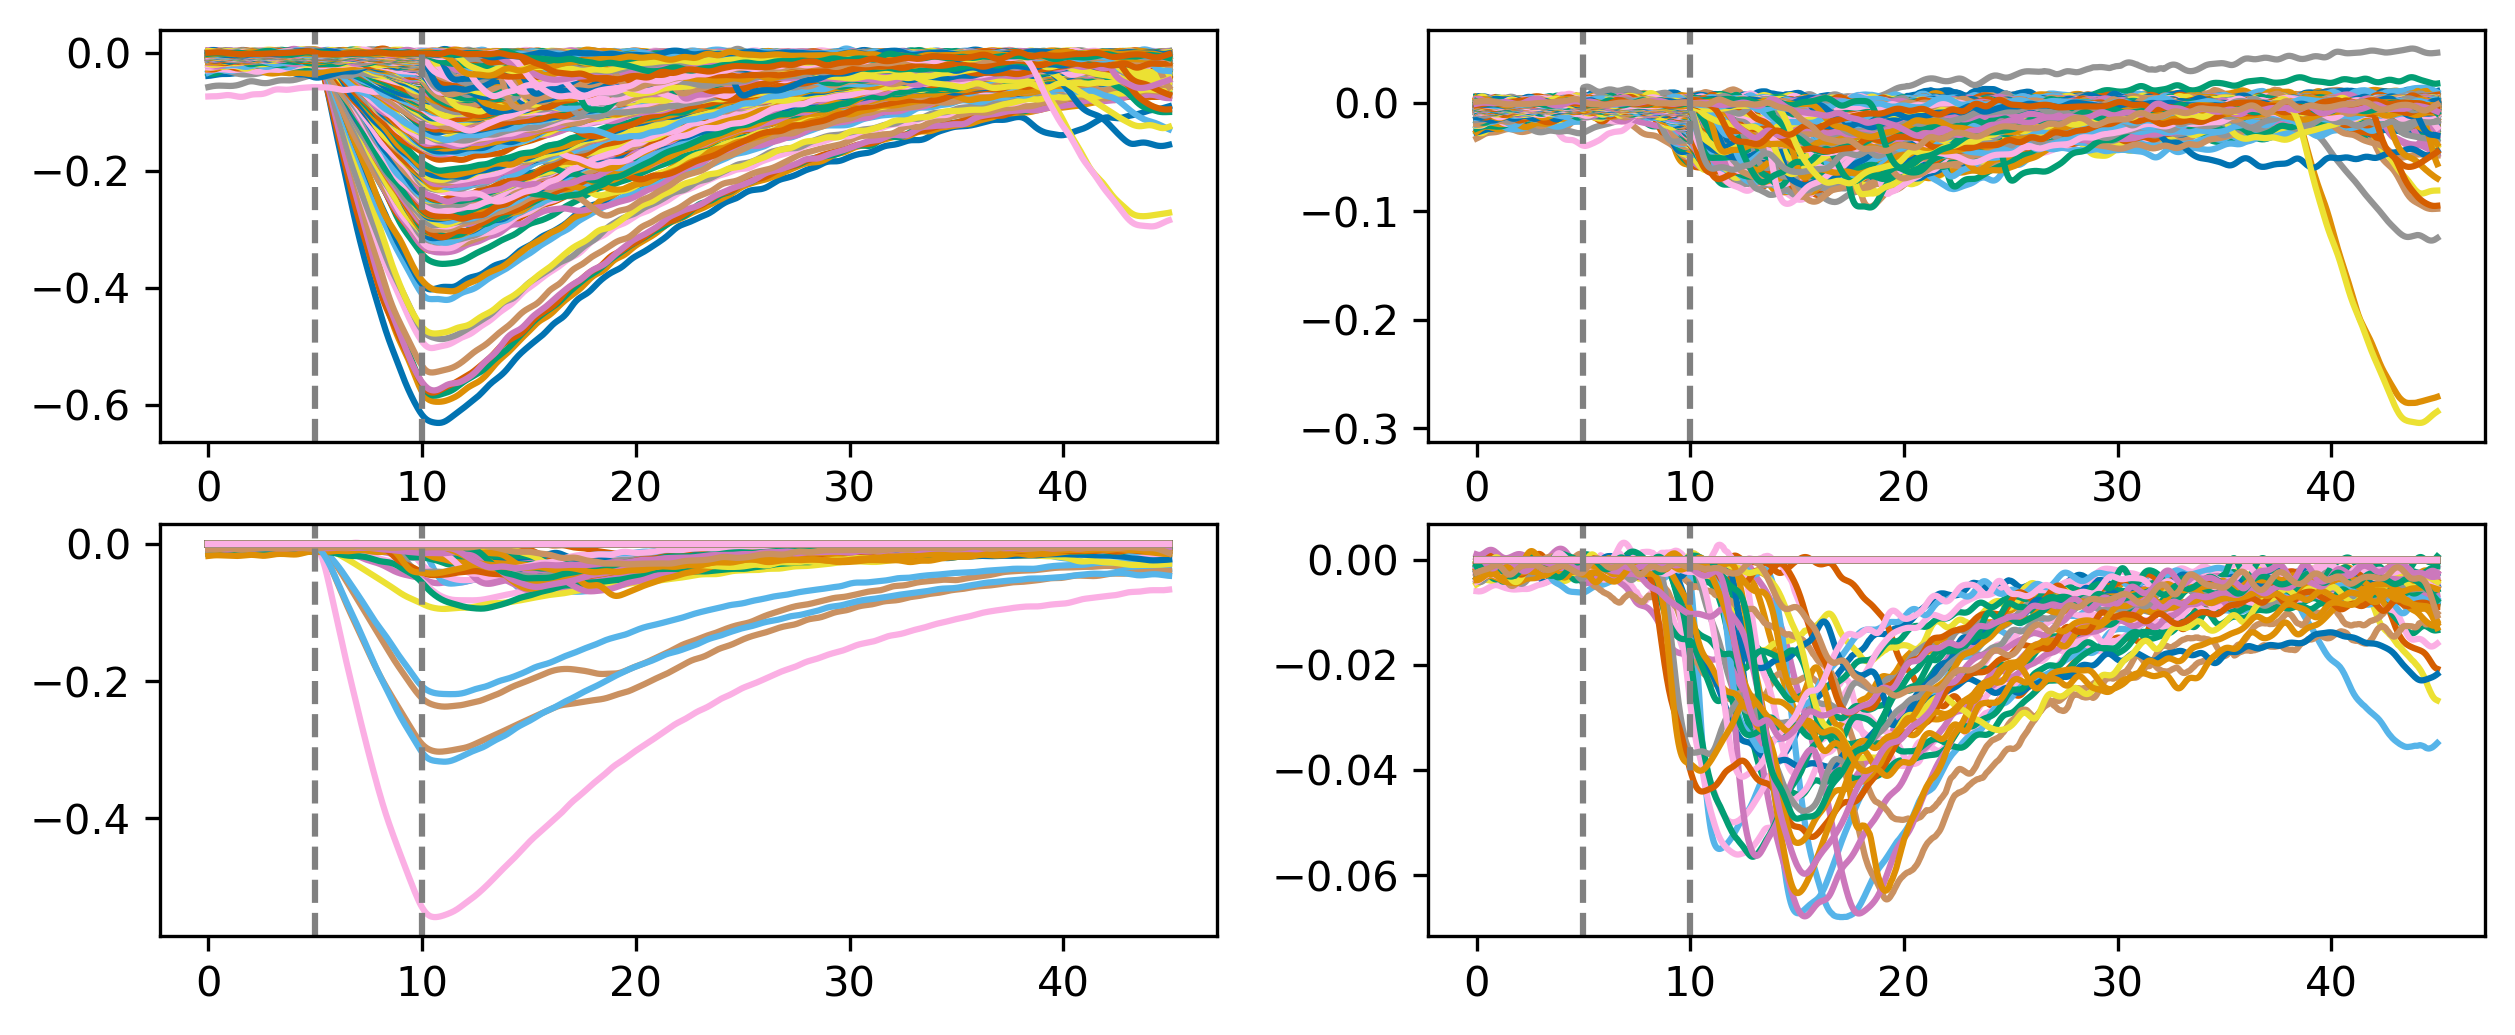

In [18]:
# plot traces from neurons that are connected without subtraction
connected_idxs_without = np.where(R.get_singlespot_weights(subtracted=False) > 0)[0]
raw_traces = R.get_singlespot_pscs(subtracted=False, neuron_idxs=connected_idxs_without)

connected_idxs_with = np.where(R.get_singlespot_weights(subtracted=True) > 0)[0]
subtracted_traces = R.get_singlespot_pscs(subtracted=True, neuron_idxs=connected_idxs_with)

# sort traces by peak amplitude during stim
raw_traces = raw_traces[np.argsort(np.max(raw_traces[:, 0:200], axis=1))[::-1], :]
subtracted_traces = subtracted_traces[np.argsort(np.max(subtracted_traces[:, 0:200], axis=1))[::-1], :]

# set seaborn to use progressive color palette
import seaborn as sns
sns.set_palette('colorblind')
fig, axs = plt.subplots(2, 2, figsize=(10, 4), dpi=300, sharey=False)
tsteps = np.arange(0, raw_traces.shape[1]) * 0.05

axs[0,0].plot(tsteps, -raw_traces.T)
axs[1,0].plot(tsteps, -ss_waveforms_without_nps[:, -1, :].T, linewidth=1.5)

axs[0,1].plot(tsteps, -subtracted_traces.T)
axs[1,1].plot(tsteps, -ss_waveforms_with_nps[:, -1, :].T, linewidth=1.5)

# annotate each axis with grey bar indicating stim onset and offset
for ax in axs.flatten():
    ax.axvline(5, color='gray', linestyle='--')
    ax.axvline(10, color='gray', linestyle='--')

KeyboardInterrupt: 

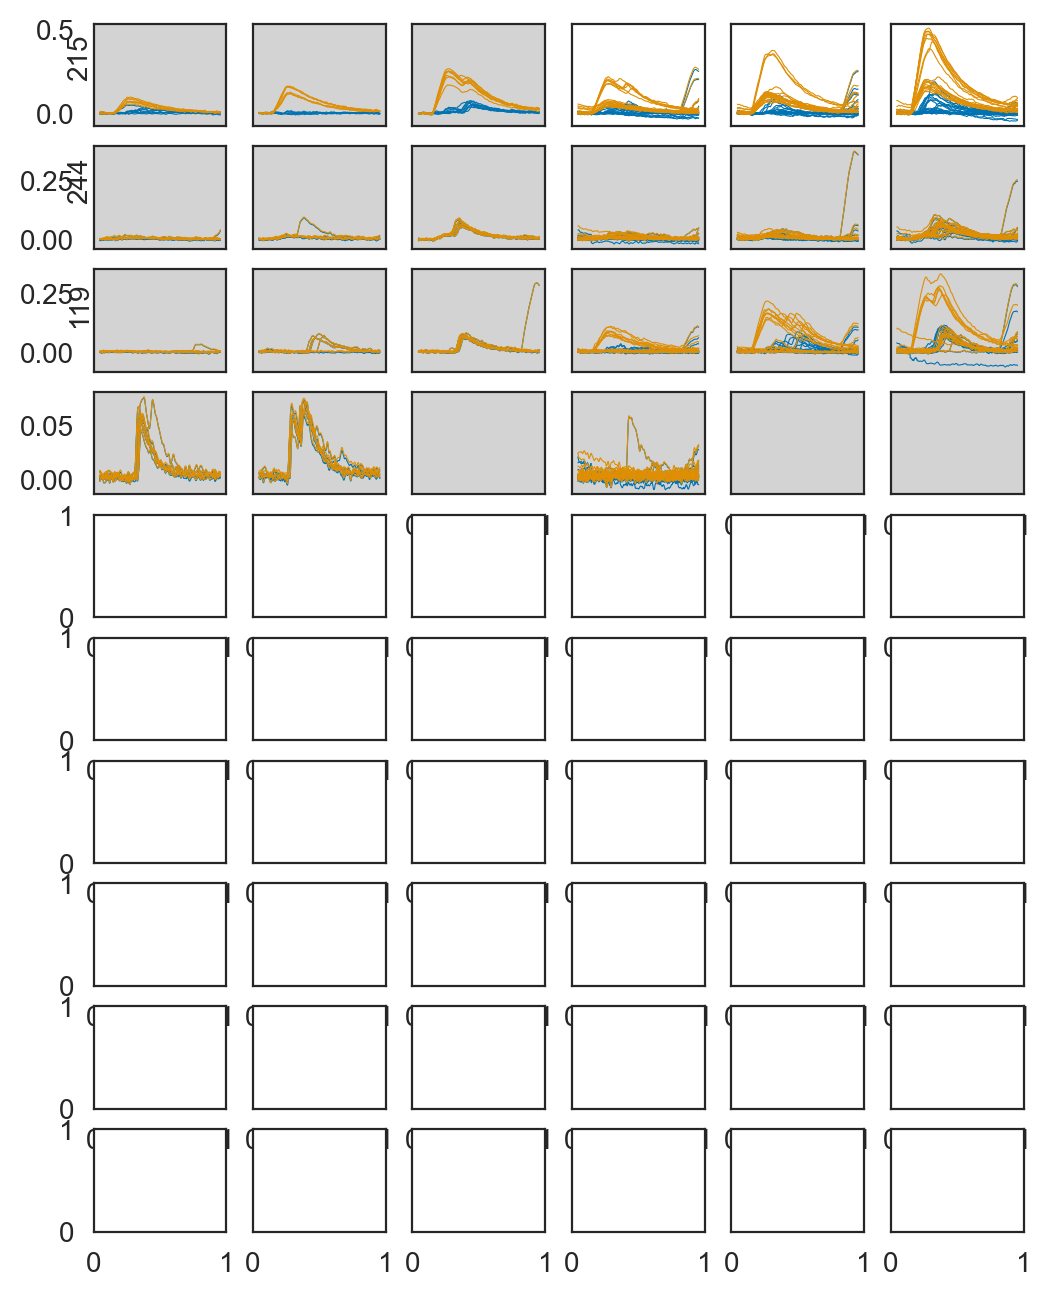

In [80]:
import seaborn as sns
sns.set_style('white')
two_colors = sns.color_palette('colorblind', 2)


# only plotting singlespot data for now
pipett_pos = np.array([250, 260])
target_distances = np.linalg.norm(results_with['targets'][:, 0:2] - pipett_pos, axis=1)

mu_without = results_without['model_state_single'].item()['mu']
mu_with = results_with['model_state_single'].item()['mu']
order = np.argsort(mu_without)[::-1]
num_powers = ss_waveforms_with_nps.shape[1]

nplots = 10


fig, axes = plt.subplots(nplots, num_powers * 2, figsize=(6, 8), sharey='row', facecolor='white', dpi=200)
for i in range(nplots):
    neuron_idx = order[i]
    # annotate rows found to be connected by singlespot
    for pidx in range(num_powers):
        if results_with['model_state_single'].item()['mu'][neuron_idx] > 0:
            axes[i, pidx].set_facecolor('lightgray')
    for pidx in range(num_powers, num_powers*2):
        if results_with['model_state_multi'].item()['mu'][neuron_idx] > 0:
            axes[i, pidx].set_facecolor('lightgray')


    for pidx, power in enumerate(np.unique(ss_powers)):
        # axes[i, pidx].plot(ss_waveforms_with_nps[neuron_idx, pidx, :], color=two_colors[0])
        # axes[i, pidx].plot(ss_waveforms_without_nps[neuron_idx, pidx, :], color=two_colors[1])

        # plot subtracted waveforms
        these_trials = np.where(results_with['stim_mat_single'][neuron_idx, :] == power)[0]
        axes[i, pidx].plot(results_with['subtracted_single'][these_trials[0:20], :].T, color=two_colors[0], linewidth=0.4)

        # plot raw waveforms
        these_trials = np.where(results_without['stim_mat_single'][neuron_idx, :] == power)[0]
        axes[i, pidx].plot(results_without['raw_single'][these_trials[0:20], :].T, color=two_colors[1], linewidth=0.4)

        # repeat, plot subtracted waveforms but for multispot data
        these_trials = np.where(results_with['stim_mat_multi'][neuron_idx, :] == power)[0]
        axes[i, pidx + num_powers].plot(results_with['subtracted_multi'][these_trials[0:20], :].T, color=two_colors[0], linewidth=0.4)

        # repeat, plot raw waveforms but for multispot data
        these_trials = np.where(results_without['stim_mat_multi'][neuron_idx, :] == power)[0]
        axes[i, pidx + num_powers].plot(results_without['raw_multi'][these_trials[0:20], :].T, color=two_colors[1], linewidth=0.4)

    # annotate each row with the number of its target
    axes[i, 0].annotate(str(neuron_idx), (-0.2, 0.5), xycoords='axes fraction', rotation=90)

 # add vertical dotted grey lines at indices 100 and 200
for i in range(nplots):
    for pidx in range(num_powers * 2):
        axes[i, pidx].axvline(100, color='grey', linestyle='--')
        axes[i, pidx].axvline(200, color='grey', linestyle='--')

        # turn off y tick labels and x tick labels
        axes[i, pidx].set_xticklabels([])
        # axes[i, pidx].set_yticklabels([])
    
# title each column with its power
for pidx, power in enumerate(np.unique(results_with['powers'])):
    axes[0, pidx].set_title('%d mW' % power)
    axes[0, pidx + num_powers].set_title('%d mW' % power)


plt.tight_layout()

Text(0, 0.5, 'EPSC (pA)')

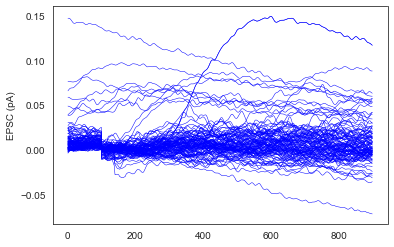

In [86]:
idxs = np.argsort(results['singlespot'].item()['raw'].mean(axis=-1))[::-1]
plt.plot(results['singlespot'].item()['raw'][idxs[0:10]].T, color='blue', linewidth=0.5)
plt.plot(results['singlespot'].item()['subtracted'][idxs[0:100]].T, color='blue', linewidth=0.5)
plt.ylabel('EPSC (pA)')